## 0. Set up preparation

### Auto-Reload

In [1]:
%load_ext autoreload
%autoreload 2
# 파이썬 코드를 실행하기 전에 항상 모든 모듈을 Reload

### Add a module path

In [2]:
import os
import sys

In [43]:
jupyter_run_dir = os.getcwd()
print(f'The current active folder is "{jupyter_run_dir}".\n')

# module path
module_dir = jupyter_run_dir + '/Splitting-data'

sys.path.append(module_dir)
print(sys.path[-1])

The current active folder is "/mnt/4d055040/lab".

/mnt/4d055040/lab/Splitting-data


In [4]:
import random
import numpy as np

def seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed()

## 1. Image to Numpy

### Retrieve all image paths
> If you want to remove a specific phrase from filenames, you can use the following function (rename_the_files).   
> Please note that 'rename_the_files' takes a list of files and removes the 'remove_str' from all of them, then saves them again.   
> So, set 'remove_str' to a character or string that exists in all the files.   

In [5]:
from utils.utils import image_valid_check

In [12]:
data_dir = '/mnt/7977asdasf/'
valid_reuslt = image_valid_check(data_dir, True)

Here are the Validation Check Results.
1. This file is not an image. -> count : 0
	e.g.None
2. This file is not in a format supported by TensorFlow OR Pytorch. -> count : 0
	e.g.None
3. This file is in a format supported by TensorFlow OR Pytorch. -> count : 886
	 class - TNBC_baseline -> count : 609
		e.g./mnt/7977asdasf/TNBC_baseline/TNBC_baseline_00.png
	 class - Normal -> count : 277
		e.g./mnt/7977asdasf/Normal/Normal_00.png


### Convert the searched images into NumPy data

In [10]:
from utils.utils import make_a_numpy_dataset

In [ ]:
dataset, classes = make_a_numpy_dataset(valid_reuslt['image'])
classes, np.unique(dataset['label'], return_counts=True)

Convert the images to numpy...
Attempting to convert the "Normal" class to a numpy array.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [00:00<00:00, 1559.04it/s]


This Class is Normal. -> shape : (277, 800, 400)

Attempting to convert the "TNBC_baseline" class to a numpy array.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 609/609 [00:00<00:00, 1669.03it/s]


This Class is TNBC_baseline. -> shape : (609, 800, 400)


Make a label...

Make a dataset...


(['Normal', 'TNBC_baseline'], (array([0, 1]), array([277, 609])))

### Check the data converted to numpy.

In [16]:
from utils.utils import show_data2img

In [34]:
check_index = [3, -5, -1]
check_items = []
for index in check_index:
    check_items.append([dataset['data'][index], dataset['label'][index]])
check_items[0], check_items[-1]

([array([[227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227],
         ...,
         [227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227],
         [227, 227, 227, ..., 227, 227, 227]], dtype=uint8),
  0],
 [array([[229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229],
         ...,
         [229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229],
         [229, 229, 229, ..., 229, 229, 229]], dtype=uint8),
  1])

Image shape: (800, 400)


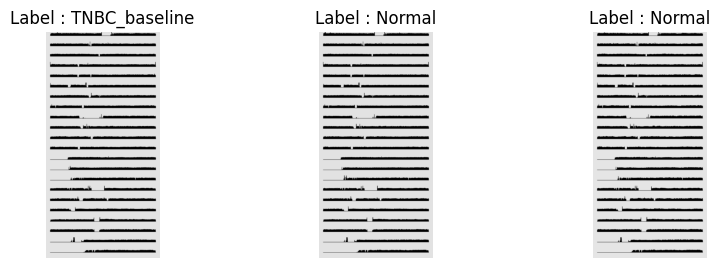

In [35]:
show_data2img(check_items, classes)

## 2. Saving
> If you want to split and save the data directly, please refer to the `1-make_a_dataset.ipynb` file for instructions.

In [37]:
from utils.utils import save_numpy_dataset

In [44]:
save_dir = '/mnt/7977asdasf/npz'
save_numpy_dataset(dataset, classes, save_dir)

save... /mnt/7977asdasf/npz/img2npz.npz
